# Clasificador de imágenes

In [1]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import np_utils
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Configuración de parámetros

In [2]:
width_shape = 224
height_shape = 224
num_classes = 10
epochs = 50
batch_size = 32 

# Path de dataset

In [3]:
train_data_dir = 'D:/Video Tutoriales/ImageClassification/dataset/train'  
validation_data_dir = 'D:/Video Tutoriales/ImageClassification/dataset/valid'

# Generador de imágenes (entrenamiento y validación)

In [4]:
train_datagen = ImageDataGenerator(  
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

valid_datagen = ImageDataGenerator(    
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(  
    train_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    #save_to_dir='',
    class_mode='categorical')

validation_generator = valid_datagen.flow_from_directory(  
    validation_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    #save_to_dir='',
    class_mode='categorical')




Found 1490 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


# Numero de imagenes de entrenamiento y validación

In [5]:
nb_train_samples = 1490
nb_validation_samples = 50

# Creación y entrenamiento de modelo CNN

In [ ]:
#Creación de modelo 
model = Sequential()

inputShape = (height_shape, width_shape, 3)
model.add(Conv2D(32,(3,3), input_shape=inputShape))
model.add(Conv2D(32,(3,3)))
model.add(MaxPool2D())
          
model.add(Conv2D(64,(3,3)))
model.add(Conv2D(64,(3,3)))
model.add(Conv2D(64,(3,3)))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(num_classes,activation='softmax', name='output'))

model.summary()

model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

model_history = model.fit_generator(  
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    validation_steps=nb_validation_samples//batch_size)

# Transfer Learning modelo VGG16 - solo agregamos capa Dense

In [ ]:
image_input = Input(shape=(width_shape, height_shape, 3))

model = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')

last_layer = model.get_layer('fc2').output
out = Dense(num_classes, activation='softmax', name='output')(last_layer)
custom_model = Model(image_input, out)

for layer in custom_model.layers[:-1]:
	layer.trainable = False
    

custom_model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

custom_model.summary()

In [ ]:
model_history = custom_model.fit_generator(  
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    validation_steps=nb_validation_samples//batch_size)

# Transfer Learning modelo VGG16 - fine tune

In [ ]:
image_input = Input(shape=(width_shape, height_shape, 3))

model2 = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')

model2.summary()

last_layer = model2.get_layer('block5_pool').output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
out = Dense(num_classes, activation='softmax', name='output')(x)
custom_model = Model(image_input, out)
custom_model.summary()

# freeze all the layers except the dense layers
for layer in custom_model.layers[:-3]:
	layer.trainable = False

custom_model.summary()

custom_model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

In [ ]:
model_history = custom_model.fit_generator(  
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    validation_steps=nb_validation_samples//batch_size)

# Transfer Learning modelo Resnet50 - fine tune

In [ ]:
from keras.applications.resnet50 import ResNet50

image_input = Input(shape=(width_shape, height_shape, 3))

m_Resnet50 = ResNet50(input_tensor=image_input, include_top=False,weights='imagenet')

m_Resnet50.summary()

last_layer = m_Resnet50.layers[-1].output

x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x=Dropout(0.3)(x)
x = Dense(128, activation='relu', name='fc2')(x)
x=Dropout(0.3)(x)
out = Dense(num_classes, activation='softmax', name='output')(x)
custom_model = Model(image_input, out)
custom_model.summary()

# freeze all the layers except the dense layers
for layer in custom_model.layers[:-6]:
    layer.trainable = False

    
custom_model.summary()

custom_model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

In [ ]:
model_history = custom_model.fit_generator(  
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    validation_steps=nb_validation_samples//batch_size)

# Transfer Learning modelo VGG19 - fine tune

In [ ]:
from keras.applications.vgg19 import VGG19


image_input = Input(shape=(width_shape, height_shape, 3))

m_VGG19 = VGG19(input_tensor=image_input, include_top=False,weights='imagenet')

m_VGG19.summary()

last_layer = m_VGG19.layers[-1].output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x=Dropout(0.3)(x)
x = Dense(128, activation='relu', name='fc2')(x)
x=Dropout(0.3)(x)
out = Dense(num_classes, activation='softmax', name='output')(x)
custom_model = Model(image_input, out)
custom_model.summary()

# freeze all the layers except the dense layers
for layer in custom_model.layers[:-6]:
	layer.trainable = False

custom_model.summary()

custom_model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

In [ ]:
model_history = custom_model.fit_generator(  
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    validation_steps=nb_validation_samples//batch_size)

# Modelo Mobilenet - Entrenamiento de toda la red


In [8]:
from keras.applications.mobilenet import MobileNet


image_input = Input(shape=(width_shape, height_shape, 3))

m_MobileNet = MobileNet(input_tensor=image_input, include_top=False,weights='imagenet')


m_MobileNet.summary()

last_layer = m_MobileNet.layers[-1].output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x=Dropout(0.3)(x)
x = Dense(128, activation='relu', name='fc2')(x)
x=Dropout(0.3)(x)
out = Dense(num_classes, activation='softmax', name='output')(x)
custom_model = Model(image_input, out)
custom_model.summary()




custom_model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [9]:
model_history = custom_model.fit_generator(  
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    validation_steps=nb_validation_samples//batch_size)

Epoch 1/50
46/46 [==============================] - 47s 1s/step - loss: 3.6916 - accuracy: 0.2085 - val_loss: 1.7690 - val_accuracy: 0.3125
Epoch 2/50
46/46 [==============================] - 35s 770ms/step - loss: 1.7732 - accuracy: 0.3957 - val_loss: 1.3885 - val_accuracy: 0.5000
Epoch 3/50
46/46 [==============================] - 36s 772ms/step - loss: 1.5379 - accuracy: 0.4918 - val_loss: 1.4565 - val_accuracy: 0.5000
Epoch 4/50
46/46 [==============================] - 35s 770ms/step - loss: 1.4711 - accuracy: 0.4973 - val_loss: 1.6875 - val_accuracy: 0.2778
Epoch 5/50
46/46 [==============================] - 36s 773ms/step - loss: 1.4285 - accuracy: 0.5261 - val_loss: 1.6269 - val_accuracy: 0.4062
Epoch 6/50
46/46 [==============================] - 35s 771ms/step - loss: 1.4332 - accuracy: 0.5288 - val_loss: 2.3278 - val_accuracy: 0.3333
Epoch 7/50
46/46 [==============================] - 36s 775ms/step - loss: 1.3047 - accuracy: 0.5604 - val_loss: 1.4131 - val_accuracy: 0.4688
Ep

# Grabar modelo en disco

In [ ]:
custom_model.save("model_Mobilenet.h5")


# Gráficas de entrenamiento y validación (accuracy - loss)

In [10]:

def plotTraining(hist, epochs, typeData):
    
    if typeData=="loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-r',label='Loss Training')
    if typeData=="accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-r',label='Accuracy Training')
    if typeData=="val_loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['val_loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'--b',label='Loss Validate')
    if typeData=="val_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['val_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'--b',label='Training Validate')
        

    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.rc('legend', fontsize=18) 
    plt.legend()
    plt.xlabel('Number of Epochs',fontsize=24)
    plt.grid(True)

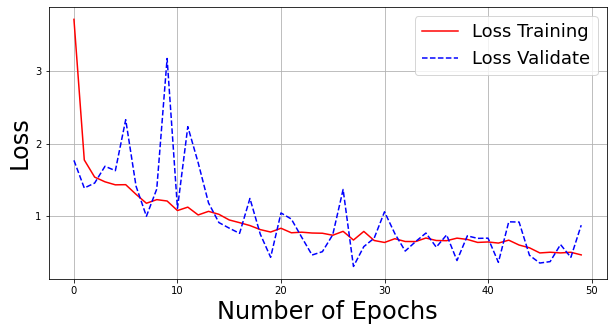

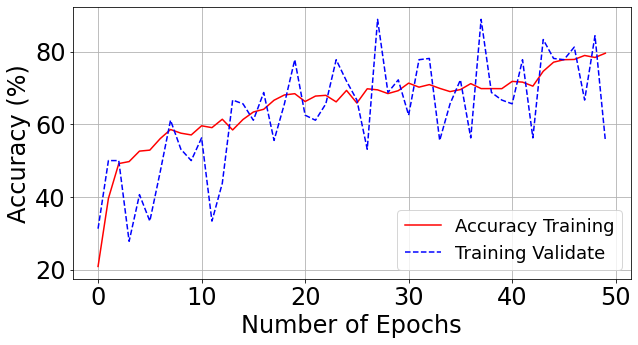

In [11]:
plotTraining(model_history,epochs,"loss")
plotTraining(model_history,epochs,"accuracy")
plotTraining(model_history,epochs,"val_loss")
plotTraining(model_history,epochs,"val_accuracy")

# Predicción usando el modelo entrenado

In [ ]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model

names = ['AFRICAN FIREFINCH','ALBATROSS','ALEXANDRINE PARAKEET','AMERICAN AVOCET','AMERICAN BITTERN',
         'AMERICAN COOT','AMERICAN GOLDFINCH','AMERICAN KESTREL','AMERICAN PIPIT','AMERICAN REDSTART']

modelt = load_model("model_VGG16.h5")
#modelt = custom_model

imaget_path = "D:/Video Tutoriales/ImageClassification/dataset/test/AMERICAN BITTERN/5.jpg"
imaget=cv2.resize(cv2.imread(imaget_path), (width_shape, height_shape), interpolation = cv2.INTER_AREA)
xt = np.asarray(imaget)
xt=preprocess_input(xt)
xt = np.expand_dims(xt,axis=0)
preds = modelt.predict(xt)

print(names[np.argmax(preds)])
plt.imshow(cv2.cvtColor(np.asarray(imaget),cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Matriz de confusión y métricas de desempeño

Found 50 images belonging to 10 classes.
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         5
           1     0.6250    1.0000    0.7692         5
           2     1.0000    1.0000    1.0000         5
           3     1.0000    1.0000    1.0000         5
           4     1.0000    1.0000    1.0000         5
           5     1.0000    0.8000    0.8889         5
           6     0.8333    1.0000    0.9091         5
           7     1.0000    0.6000    0.7500         5
           8     0.7143    1.0000    0.8333         5
           9     1.0000    0.4000    0.5714         5

    accuracy                         0.8800        50
   macro avg     0.9173    0.8800    0.8722        50
weighted avg     0.9173    0.8800    0.8722        50



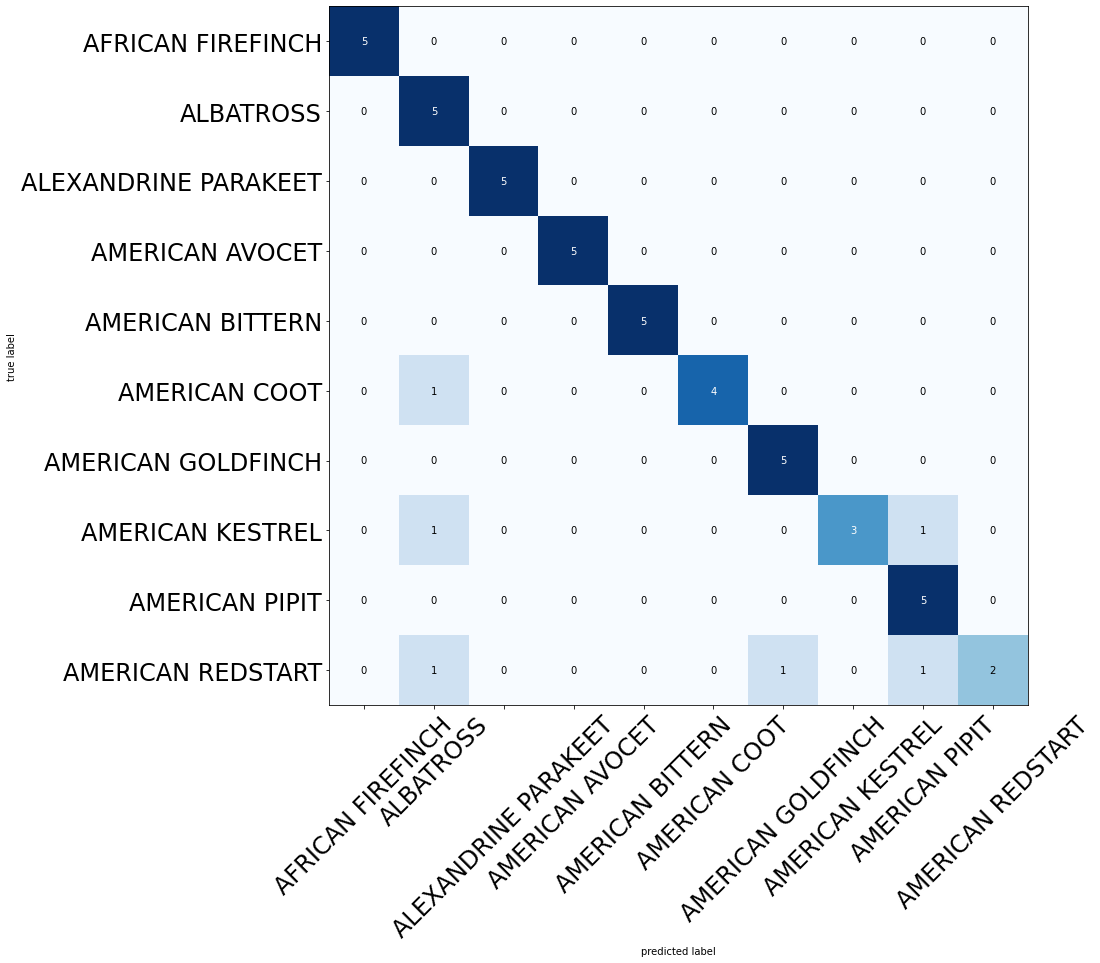

In [12]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


names = ['AFRICAN FIREFINCH','ALBATROSS','ALEXANDRINE PARAKEET','AMERICAN AVOCET','AMERICAN BITTERN',
         'AMERICAN COOT','AMERICAN GOLDFINCH','AMERICAN KESTREL','AMERICAN PIPIT','AMERICAN REDSTART']


test_data_dir = 'D:/Video Tutoriales/ImageClassification/dataset/test'  

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(width_shape, height_shape), 
    batch_size = batch_size,
    class_mode='categorical', 
    shuffle=False)

custom_Model= load_model("model_Mobilenet.h5")
#modelt = custom_model

predictions = custom_Model.predict_generator(generator=test_generator)

y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes


matc=confusion_matrix(y_real, y_pred)

plot_confusion_matrix(conf_mat=matc, figsize=(15,15), class_names = names, show_normed=False)
plt.tight_layout()

print(metrics.classification_report(y_real,y_pred, digits = 4))